# Dogs vs. Cats

Базовая модель -  inceptionV4 https://github.com/kentsommer/keras-inceptionV4
Используемая аугментация тренировочных данных - central_crop в диапазоне 0.75..1.0 и случайный np.fliplr
К результату применяю np.clip(pred,0.015,0.985)

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
sys.path.append("./inceptionV4")

In [3]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [4]:
from keras import backend as K


In [5]:
import cv2

In [6]:
import inception_v4

In [7]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

## Функции загрузки данных

In [8]:
import re
import random
from random import shuffle
from glob import glob

path='/app/data/catsndogs/'
train_files = glob(path+'./train/*.jpg')
test_files = glob(path+'./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def central_crop(image, central_fraction):
    if central_fraction <= 0.0 or central_fraction > 1.0:
        raise ValueError('central_fraction must be within (0, 1]')
    if central_fraction == 1.0:
        return image

    img_shape = image.shape
    depth = img_shape[2]
    fraction_offset = int(1 / ((1 - central_fraction) / 2.0))
    bbox_h_start = int(np.divide(img_shape[0], fraction_offset))
    bbox_w_start = int(np.divide(img_shape[1], fraction_offset))

    bbox_h_size = int(img_shape[0] - bbox_h_start * 2)
    bbox_w_size = int(img_shape[1] - bbox_w_start * 2)

    image = image[bbox_h_start:bbox_h_start+bbox_h_size, bbox_w_start:bbox_w_start+bbox_w_size]
    return image

def load_image(img_path,variate=False):
    # Load image and convert from BGR to RGB
    im = np.asarray(cv2.imread(img_path))[:,:,::-1]
    if variate:
        im = central_crop(im, random.randrange(750,1000)/1000.0)
        if random.randint(0,2)==0:
            im=np.fliplr(im)
    else:
        im = central_crop(im, 0.875)
    im = cv2.resize(im, (299, 299))
    im = inception_v4.preprocess_input(im)
    if K.image_data_format() == "channels_first":
        im = np.transpose(im, (2,0,1))
        im = im.reshape(3,299,299)
    else:
        im = im.reshape(299,299,3)
    return im

def load_image_vgg(path, target_size=IMG_SIZE,variate=False):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    
    if variate:
        ar=np.array(img)
        w=ar.shape[1]
        h=ar.shape[0]
        ar2=ar[random.randrange(0,int(h*0.2)):h-random.randrange(0,int(h*0.2)), random.randrange(0,int(w*0.2)):w-random.randrange(0,int(w*0.2)),]
        if random.randint(0,2)==0:
            ar2=np.fliplr(ar2)
        array=ar2
    else:
        array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path,variate=True) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

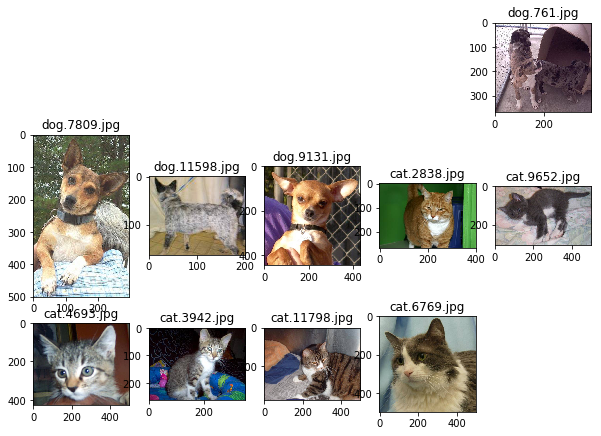

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [14]:
base_model = inception_v4.create_model(weights='imagenet', include_top=False,)

In [15]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [16]:
base_model.output

<tf.Tensor 'concatenate_25/concat:0' shape=(?, 8, 8, 1536) dtype=float32>

## Добавляем полносвязный слой

In [17]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Компилируем модель и запускаем обучение

In [25]:
import keras.optimizers
sgd=keras.optimizers.sgd(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd, 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [26]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 1000  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=1000,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/1000
10/10 [==============================] - 16s - loss: 1.1975 - acc: 0.9469 - val_loss: 0.9933 - val_acc: 0.9730
Epoch 2/1000
10/10 [==============================] - 15s - loss: 0.8630 - acc: 0.9938 - val_loss: 0.9165 - val_acc: 0.9920
Epoch 3/1000
10/10 [==============================] - 15s - loss: 0.9078 - acc: 0.9875 - val_loss: 0.9339 - val_acc: 0.9880
Epoch 4/1000
10/10 [==============================] - 15s - loss: 0.9222 - acc: 0.9812 - val_loss: 1.0067 - val_acc: 0.9680
Epoch 5/1000
10/10 [==============================] - 15s - loss: 1.0536 - acc: 0.9719 - val_loss: 0.9241 - val_acc: 0.9890
Epoch 6/1000
10/10 [==============================] - 15s - loss: 0.9870 - acc: 0.9719 - val_loss: 1.1751 - val_acc: 0.9370
Epoch 7/1000
10/10 [==============================] - 15s - loss: 1.0762 - acc: 0.9531 - val_loss: 0.9085 - val_acc: 0.9920
Epoch 8/1000
10/10 [==============================] - 15s - loss: 1.0780 - acc: 0.9656 - val_loss: 0.9283 - val_acc: 0.9870
Epoch 9/

10/10 [==============================] - 15s - loss: 1.1281 - acc: 0.9625 - val_loss: 0.9221 - val_acc: 0.9890
Epoch 67/1000
10/10 [==============================] - 15s - loss: 1.1474 - acc: 0.9656 - val_loss: 0.9189 - val_acc: 0.9880
Epoch 68/1000
10/10 [==============================] - 15s - loss: 1.0669 - acc: 0.9625 - val_loss: 0.9147 - val_acc: 0.9880
Epoch 69/1000
10/10 [==============================] - 15s - loss: 1.0096 - acc: 0.9719 - val_loss: 1.0126 - val_acc: 0.9690
Epoch 70/1000
10/10 [==============================] - 15s - loss: 1.0234 - acc: 0.9594 - val_loss: 0.9387 - val_acc: 0.9860
Epoch 71/1000
10/10 [==============================] - 15s - loss: 0.9294 - acc: 0.9719 - val_loss: 0.9146 - val_acc: 0.9880
Epoch 72/1000
10/10 [==============================] - 15s - loss: 1.0084 - acc: 0.9688 - val_loss: 0.9699 - val_acc: 0.9810
Epoch 73/1000
10/10 [==============================] - 15s - loss: 1.0005 - acc: 0.9781 - val_loss: 1.0190 - val_acc: 0.9680
Epoch 74/1000


10/10 [==============================] - 15s - loss: 1.0548 - acc: 0.9719 - val_loss: 0.8820 - val_acc: 0.9910
Epoch 132/1000
10/10 [==============================] - 15s - loss: 1.0873 - acc: 0.9688 - val_loss: 0.9006 - val_acc: 0.9880
Epoch 133/1000
10/10 [==============================] - 15s - loss: 0.9281 - acc: 0.9844 - val_loss: 0.9421 - val_acc: 0.9810
Epoch 134/1000
10/10 [==============================] - 15s - loss: 1.1281 - acc: 0.9594 - val_loss: 0.9562 - val_acc: 0.9770
Epoch 135/1000
10/10 [==============================] - 15s - loss: 0.9230 - acc: 0.9812 - val_loss: 0.9457 - val_acc: 0.9830
Epoch 136/1000
10/10 [==============================] - 15s - loss: 0.9818 - acc: 0.9812 - val_loss: 0.8822 - val_acc: 0.9900
Epoch 137/1000
10/10 [==============================] - 15s - loss: 0.9820 - acc: 0.9750 - val_loss: 0.8846 - val_acc: 0.9920
Epoch 138/1000
10/10 [==============================] - 15s - loss: 0.9088 - acc: 0.9812 - val_loss: 0.9072 - val_acc: 0.9870
Epoch 1

10/10 [==============================] - 15s - loss: 0.8908 - acc: 0.9812 - val_loss: 0.8853 - val_acc: 0.9920
Epoch 197/1000
10/10 [==============================] - 15s - loss: 1.0767 - acc: 0.9625 - val_loss: 0.9177 - val_acc: 0.9870
Epoch 198/1000
10/10 [==============================] - 15s - loss: 1.0497 - acc: 0.9688 - val_loss: 0.9796 - val_acc: 0.9780
Epoch 199/1000
10/10 [==============================] - 15s - loss: 1.0171 - acc: 0.9781 - val_loss: 0.9142 - val_acc: 0.9860
Epoch 200/1000
10/10 [==============================] - 15s - loss: 0.9150 - acc: 0.9781 - val_loss: 0.8922 - val_acc: 0.9910
Epoch 201/1000
10/10 [==============================] - 15s - loss: 1.0098 - acc: 0.9688 - val_loss: 0.8864 - val_acc: 0.9900
Epoch 202/1000
10/10 [==============================] - 15s - loss: 0.9226 - acc: 0.9750 - val_loss: 1.0299 - val_acc: 0.9670
Epoch 203/1000
10/10 [==============================] - 15s - loss: 0.9993 - acc: 0.9719 - val_loss: 0.9168 - val_acc: 0.9850
Epoch 2

10/10 [==============================] - 15s - loss: 0.9840 - acc: 0.9719 - val_loss: 0.9052 - val_acc: 0.9910
Epoch 262/1000
10/10 [==============================] - 15s - loss: 0.9654 - acc: 0.9688 - val_loss: 0.8834 - val_acc: 0.9900
Epoch 263/1000
10/10 [==============================] - 15s - loss: 0.9420 - acc: 0.9750 - val_loss: 0.8797 - val_acc: 0.9900
Epoch 264/1000
10/10 [==============================] - 15s - loss: 0.9193 - acc: 0.9781 - val_loss: 0.8944 - val_acc: 0.9920
Epoch 265/1000
10/10 [==============================] - 15s - loss: 0.9060 - acc: 0.9844 - val_loss: 0.9010 - val_acc: 0.9900
Epoch 266/1000
10/10 [==============================] - 15s - loss: 0.8936 - acc: 0.9906 - val_loss: 0.8851 - val_acc: 0.9900
Epoch 267/1000
10/10 [==============================] - 15s - loss: 0.9873 - acc: 0.9656 - val_loss: 0.8829 - val_acc: 0.9900
Epoch 268/1000
10/10 [==============================] - 15s - loss: 1.1330 - acc: 0.9563 - val_loss: 0.9024 - val_acc: 0.9880
Epoch 2

10/10 [==============================] - 15s - loss: 0.8308 - acc: 0.9938 - val_loss: 0.9106 - val_acc: 0.9820
Epoch 327/1000
10/10 [==============================] - 15s - loss: 0.9471 - acc: 0.9750 - val_loss: 0.8759 - val_acc: 0.9910
Epoch 328/1000
10/10 [==============================] - 15s - loss: 0.9412 - acc: 0.9656 - val_loss: 0.8872 - val_acc: 0.9860
Epoch 329/1000
10/10 [==============================] - 15s - loss: 0.9412 - acc: 0.9750 - val_loss: 0.9639 - val_acc: 0.9800
Epoch 330/1000
10/10 [==============================] - 15s - loss: 0.8759 - acc: 0.9812 - val_loss: 0.8897 - val_acc: 0.9870
Epoch 331/1000
10/10 [==============================] - 15s - loss: 0.8867 - acc: 0.9875 - val_loss: 0.9140 - val_acc: 0.9860
Epoch 332/1000
10/10 [==============================] - 15s - loss: 1.3691 - acc: 0.9281 - val_loss: 0.9654 - val_acc: 0.9800
Epoch 333/1000
10/10 [==============================] - 15s - loss: 1.0163 - acc: 0.9750 - val_loss: 0.9582 - val_acc: 0.9790
Epoch 3

10/10 [==============================] - 15s - loss: 0.8561 - acc: 0.9875 - val_loss: 0.8928 - val_acc: 0.9900
Epoch 392/1000
10/10 [==============================] - 15s - loss: 0.8677 - acc: 0.9875 - val_loss: 0.8912 - val_acc: 0.9880
Epoch 393/1000
10/10 [==============================] - 15s - loss: 0.9745 - acc: 0.9688 - val_loss: 0.9135 - val_acc: 0.9840
Epoch 394/1000
10/10 [==============================] - 15s - loss: 0.8543 - acc: 0.9906 - val_loss: 0.9029 - val_acc: 0.9850
Epoch 395/1000
10/10 [==============================] - 15s - loss: 0.9149 - acc: 0.9906 - val_loss: 0.9540 - val_acc: 0.9800
Epoch 396/1000
10/10 [==============================] - 15s - loss: 0.9529 - acc: 0.9844 - val_loss: 0.8979 - val_acc: 0.9870
Epoch 397/1000
10/10 [==============================] - 15s - loss: 0.9606 - acc: 0.9719 - val_loss: 0.8862 - val_acc: 0.9880
Epoch 398/1000
10/10 [==============================] - 15s - loss: 0.9460 - acc: 0.9750 - val_loss: 0.9204 - val_acc: 0.9840
Epoch 3

10/10 [==============================] - 15s - loss: 0.8727 - acc: 0.9875 - val_loss: 0.8989 - val_acc: 0.9880
Epoch 457/1000
10/10 [==============================] - 15s - loss: 0.9314 - acc: 0.9781 - val_loss: 0.8947 - val_acc: 0.9890
Epoch 458/1000
10/10 [==============================] - 15s - loss: 0.8526 - acc: 0.9875 - val_loss: 0.8903 - val_acc: 0.9880
Epoch 459/1000
10/10 [==============================] - 15s - loss: 1.0205 - acc: 0.9656 - val_loss: 0.9292 - val_acc: 0.9840
Epoch 460/1000
10/10 [==============================] - 15s - loss: 0.8610 - acc: 0.9875 - val_loss: 0.9278 - val_acc: 0.9860
Epoch 461/1000
10/10 [==============================] - 15s - loss: 0.8805 - acc: 0.9875 - val_loss: 0.8888 - val_acc: 0.9900
Epoch 462/1000
10/10 [==============================] - 15s - loss: 0.9547 - acc: 0.9750 - val_loss: 0.8891 - val_acc: 0.9910
Epoch 463/1000
10/10 [==============================] - 15s - loss: 0.9007 - acc: 0.9875 - val_loss: 0.8958 - val_acc: 0.9860
Epoch 4

10/10 [==============================] - 15s - loss: 0.8342 - acc: 0.9938 - val_loss: 0.8885 - val_acc: 0.9880
Epoch 522/1000
10/10 [==============================] - 15s - loss: 0.8540 - acc: 0.9906 - val_loss: 0.8982 - val_acc: 0.9890
Epoch 523/1000
10/10 [==============================] - 15s - loss: 0.8404 - acc: 0.9938 - val_loss: 0.8834 - val_acc: 0.9870
Epoch 524/1000
10/10 [==============================] - 15s - loss: 0.8907 - acc: 0.9781 - val_loss: 0.8837 - val_acc: 0.9880
Epoch 525/1000
10/10 [==============================] - 15s - loss: 0.8629 - acc: 0.9812 - val_loss: 0.8912 - val_acc: 0.9860
Epoch 526/1000
10/10 [==============================] - 15s - loss: 0.9050 - acc: 0.9812 - val_loss: 0.9238 - val_acc: 0.9810
Epoch 527/1000
10/10 [==============================] - 15s - loss: 0.9931 - acc: 0.9781 - val_loss: 0.8851 - val_acc: 0.9870
Epoch 528/1000
10/10 [==============================] - 15s - loss: 0.9135 - acc: 0.9844 - val_loss: 0.9021 - val_acc: 0.9880
Epoch 5

10/10 [==============================] - 15s - loss: 1.1537 - acc: 0.9594 - val_loss: 0.9664 - val_acc: 0.9800
Epoch 587/1000
10/10 [==============================] - 15s - loss: 0.8333 - acc: 0.9906 - val_loss: 0.9397 - val_acc: 0.9780
Epoch 588/1000
10/10 [==============================] - 15s - loss: 0.9620 - acc: 0.9781 - val_loss: 0.8859 - val_acc: 0.9890
Epoch 589/1000
10/10 [==============================] - 15s - loss: 0.9052 - acc: 0.9844 - val_loss: 0.9374 - val_acc: 0.9820
Epoch 590/1000
10/10 [==============================] - 15s - loss: 0.8661 - acc: 0.9812 - val_loss: 0.8879 - val_acc: 0.9890
Epoch 591/1000
10/10 [==============================] - 15s - loss: 0.8893 - acc: 0.9750 - val_loss: 0.9301 - val_acc: 0.9850
Epoch 592/1000
10/10 [==============================] - 15s - loss: 0.8939 - acc: 0.9812 - val_loss: 0.9452 - val_acc: 0.9770
Epoch 593/1000
10/10 [==============================] - 15s - loss: 0.9849 - acc: 0.9781 - val_loss: 0.9048 - val_acc: 0.9860
Epoch 5

10/10 [==============================] - 15s - loss: 0.8775 - acc: 0.9844 - val_loss: 0.8825 - val_acc: 0.9880
Epoch 652/1000
10/10 [==============================] - 15s - loss: 0.8832 - acc: 0.9906 - val_loss: 0.8908 - val_acc: 0.9810
Epoch 653/1000
10/10 [==============================] - 15s - loss: 0.9624 - acc: 0.9688 - val_loss: 0.9039 - val_acc: 0.9810
Epoch 654/1000
10/10 [==============================] - 15s - loss: 0.9355 - acc: 0.9844 - val_loss: 0.9422 - val_acc: 0.9800
Epoch 655/1000
10/10 [==============================] - 15s - loss: 0.8731 - acc: 0.9906 - val_loss: 0.8873 - val_acc: 0.9870
Epoch 656/1000
10/10 [==============================] - 15s - loss: 0.8755 - acc: 0.9875 - val_loss: 0.8966 - val_acc: 0.9860
Epoch 657/1000
10/10 [==============================] - 15s - loss: 0.8737 - acc: 0.9906 - val_loss: 0.9082 - val_acc: 0.9830
Epoch 658/1000
10/10 [==============================] - 15s - loss: 0.8728 - acc: 0.9844 - val_loss: 0.8937 - val_acc: 0.9840
Epoch 6

10/10 [==============================] - 15s - loss: 0.8359 - acc: 0.9938 - val_loss: 0.8893 - val_acc: 0.9870
Epoch 717/1000
10/10 [==============================] - 15s - loss: 0.8999 - acc: 0.9844 - val_loss: 0.9042 - val_acc: 0.9850
Epoch 718/1000
10/10 [==============================] - 15s - loss: 1.0689 - acc: 0.9500 - val_loss: 0.9365 - val_acc: 0.9810
Epoch 719/1000
10/10 [==============================] - 15s - loss: 0.8806 - acc: 0.9906 - val_loss: 0.8904 - val_acc: 0.9850
Epoch 720/1000
10/10 [==============================] - 15s - loss: 0.8316 - acc: 0.9938 - val_loss: 0.9054 - val_acc: 0.9820
Epoch 721/1000
10/10 [==============================] - 15s - loss: 0.9063 - acc: 0.9812 - val_loss: 0.8919 - val_acc: 0.9880
Epoch 722/1000
10/10 [==============================] - 15s - loss: 0.9116 - acc: 0.9812 - val_loss: 0.8882 - val_acc: 0.9900
Epoch 723/1000
10/10 [==============================] - 15s - loss: 0.8793 - acc: 0.9875 - val_loss: 0.9151 - val_acc: 0.9820
Epoch 7

10/10 [==============================] - 15s - loss: 0.9106 - acc: 0.9875 - val_loss: 0.9130 - val_acc: 0.9850
Epoch 782/1000
10/10 [==============================] - 15s - loss: 0.9099 - acc: 0.9750 - val_loss: 0.9116 - val_acc: 0.9840
Epoch 783/1000
10/10 [==============================] - 15s - loss: 0.8644 - acc: 0.9875 - val_loss: 0.8866 - val_acc: 0.9870
Epoch 784/1000
10/10 [==============================] - 15s - loss: 0.8683 - acc: 0.9844 - val_loss: 0.8800 - val_acc: 0.9880
Epoch 785/1000
10/10 [==============================] - 15s - loss: 0.8537 - acc: 0.9844 - val_loss: 0.8747 - val_acc: 0.9870
Epoch 786/1000
10/10 [==============================] - 15s - loss: 0.8949 - acc: 0.9875 - val_loss: 0.8809 - val_acc: 0.9890
Epoch 787/1000
10/10 [==============================] - 15s - loss: 0.8437 - acc: 0.9906 - val_loss: 0.8715 - val_acc: 0.9900
Epoch 788/1000
10/10 [==============================] - 15s - loss: 0.9083 - acc: 0.9844 - val_loss: 0.8723 - val_acc: 0.9900
Epoch 7

10/10 [==============================] - 15s - loss: 0.9210 - acc: 0.9750 - val_loss: 0.9147 - val_acc: 0.9840
Epoch 847/1000
10/10 [==============================] - 15s - loss: 0.9541 - acc: 0.9688 - val_loss: 0.9152 - val_acc: 0.9860
Epoch 848/1000
10/10 [==============================] - 15s - loss: 0.8750 - acc: 0.9969 - val_loss: 0.9176 - val_acc: 0.9840
Epoch 849/1000
10/10 [==============================] - 15s - loss: 0.9291 - acc: 0.9875 - val_loss: 0.9047 - val_acc: 0.9850
Epoch 850/1000
10/10 [==============================] - 15s - loss: 0.8434 - acc: 0.9906 - val_loss: 0.9151 - val_acc: 0.9840
Epoch 851/1000
10/10 [==============================] - 15s - loss: 0.8866 - acc: 0.9844 - val_loss: 0.9073 - val_acc: 0.9850
Epoch 852/1000
10/10 [==============================] - 15s - loss: 0.8539 - acc: 0.9906 - val_loss: 0.9036 - val_acc: 0.9840
Epoch 853/1000
10/10 [==============================] - 15s - loss: 0.8428 - acc: 0.9969 - val_loss: 0.9054 - val_acc: 0.9830
Epoch 8

10/10 [==============================] - 15s - loss: 0.8576 - acc: 0.9906 - val_loss: 0.9453 - val_acc: 0.9780
Epoch 912/1000
10/10 [==============================] - 15s - loss: 0.8573 - acc: 0.9906 - val_loss: 0.9176 - val_acc: 0.9840
Epoch 913/1000
10/10 [==============================] - 15s - loss: 0.8713 - acc: 0.9906 - val_loss: 0.9090 - val_acc: 0.9850
Epoch 914/1000
10/10 [==============================] - 15s - loss: 0.8608 - acc: 0.9906 - val_loss: 0.9075 - val_acc: 0.9850
Epoch 915/1000
10/10 [==============================] - 15s - loss: 0.8563 - acc: 0.9938 - val_loss: 0.9073 - val_acc: 0.9840
Epoch 916/1000
10/10 [==============================] - 15s - loss: 0.9228 - acc: 0.9781 - val_loss: 0.9166 - val_acc: 0.9820
Epoch 917/1000
10/10 [==============================] - 15s - loss: 0.8623 - acc: 0.9750 - val_loss: 0.9145 - val_acc: 0.9820
Epoch 918/1000
10/10 [==============================] - 15s - loss: 0.8466 - acc: 0.9906 - val_loss: 0.9123 - val_acc: 0.9830
Epoch 9

10/10 [==============================] - 15s - loss: 0.9092 - acc: 0.9781 - val_loss: 0.8942 - val_acc: 0.9830
Epoch 977/1000
10/10 [==============================] - 15s - loss: 0.8868 - acc: 0.9875 - val_loss: 1.0695 - val_acc: 0.9610
Epoch 978/1000
10/10 [==============================] - 15s - loss: 0.8968 - acc: 0.9875 - val_loss: 0.8880 - val_acc: 0.9860
Epoch 979/1000
10/10 [==============================] - 15s - loss: 0.9202 - acc: 0.9844 - val_loss: 0.8995 - val_acc: 0.9830
Epoch 980/1000
10/10 [==============================] - 15s - loss: 0.9182 - acc: 0.9812 - val_loss: 0.8837 - val_acc: 0.9830
Epoch 981/1000
10/10 [==============================] - 15s - loss: 0.9002 - acc: 0.9844 - val_loss: 0.8877 - val_acc: 0.9830
Epoch 982/1000
10/10 [==============================] - 15s - loss: 0.8800 - acc: 0.9844 - val_loss: 0.8897 - val_acc: 0.9820
Epoch 983/1000
10/10 [==============================] - 15s - loss: 0.9044 - acc: 0.9875 - val_loss: 0.9330 - val_acc: 0.9790
Epoch 9

## Предсказания на проверочной выборке

In [27]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

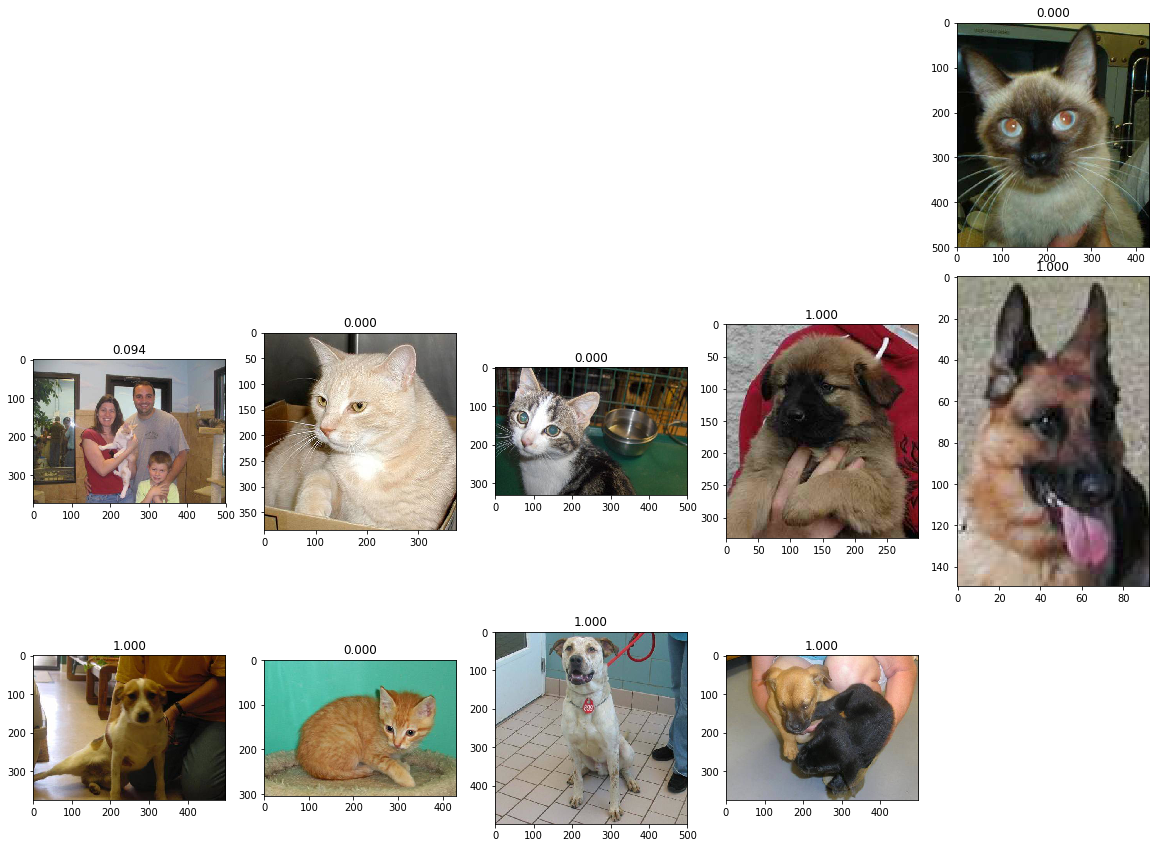

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [29]:
with open('submit_dnc.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, np.clip(pred,0.015,0.985)):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
# Kaggle score 0.0925